<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


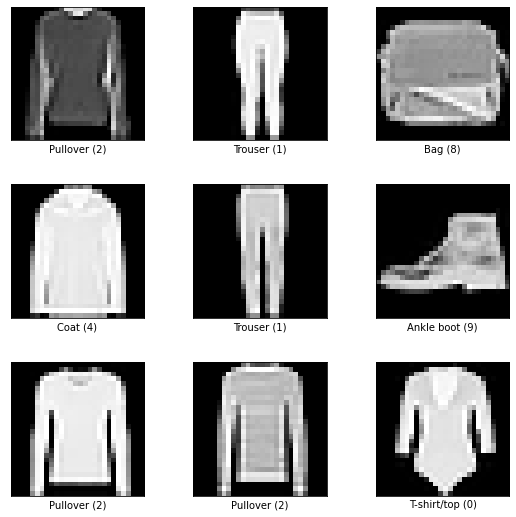

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [2]:
ds_train, ds_info = tfds.load('fashion_mnist', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_info, ds_train)
ds_info

In [3]:
batch_size = 256
image_shape = (28, 28, 1)

def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])    
    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    return image


ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size, drop_remainder=True)

train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

234


In [4]:
class GAN(Model):

    def __init__(self, generator, discriminator, z_dim):
        super(GAN, self).__init__()
        self.G = generator
        self.D = discriminator
        self.z_dim = z_dim

        generator.summary()
        discriminator.summary()
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()

        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        z = tf.random.normal(shape=(batch_size, self.z_dim))
        true_labels = tf.ones((batch_size, 1))
        false_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:

            fake_images = self.G(z)

            fake_predictions = self.D(fake_images)
            real_predictions = self.D(real_images)

            d_loss = 0.5 * (self.loss_fn(false_labels, fake_predictions) +\
                            self.loss_fn(true_labels, real_predictions))
            g_loss = self.loss_fn(fake_predictions, true_labels)

            fake_accuracy = tf.reduce_mean(binary_accuracy(fake_predictions, false_labels))
            real_accuracy = tf.reduce_mean(binary_accuracy(real_predictions, true_labels))
        
        d_grads = d_tape.gradient(d_loss, self.D.trainable_variables)
        g_grads = g_tape.gradient(g_loss, self.G.trainable_variables)


        self.d_optimizer.apply_gradients(zip(d_grads, self.D.trainable_variables))
        self.g_optimizer.apply_gradients(zip(g_grads, self.G.trainable_variables))

        return {'d_loss': d_loss, 'g_loss': g_loss, 'fake_accuracy': fake_accuracy, 'real_accuracy': real_accuracy}
    
    def call(self, num_imgs):
        z = tf.random.normal(shape=(num_imgs, self.z_dim))
        return self.G(z)

In [5]:
class DCGAN(GAN):

    def __init__(self, z_dim, input_shape):
        
        discriminator = self.discriminator(input_shape)
        generator = self.generator(z_dim)
        super().__init__(generator, discriminator, z_dim)
    
    def generator(self, z_dim):
        return Sequential([
            layers.Dense(7*7*64, input_shape=(z_dim,)),
            layers.BatchNormalization(momentum=0.9),
            layers.ReLU(),
            layers.Reshape((7, 7, 64)),
            
            layers.Conv2D(64, 3, padding='same'), 
            layers.BatchNormalization(momentum=0.9),
            layers.ReLU(),         
            layers.UpSampling2D((2,2), interpolation="bilinear"),

            layers.Conv2D(32, 3, padding='same'), 
            layers.ReLU(),         
            layers.UpSampling2D((2,2), interpolation="bilinear"),

            layers.Conv2D(image_shape[-1], 3, padding='same', activation='tanh')
        ], name='Generator')
    
    def discriminator(self, input_shape):
        return Sequential([
            layers.Conv2D(32, 3, strides=(2,2), padding='same', input_shape=input_shape),
            layers.BatchNormalization(momentum=0.9),
            layers.LeakyReLU(0.2), 
            layers.Dropout(0.2),

            layers.Conv2D(64, 3, strides=(2,2), padding='same'),
            layers.BatchNormalization(momentum=0.9),
            layers.LeakyReLU(0.2), 
            layers.Dropout(0.2),

            layers.Flatten(),
            layers.Dense(1, activation='sigmoid')                 
        ], name='Discriminator')

In [6]:
class GenerativeCallback(tf.keras.callbacks.Callback):

    def __init__(self, num_imgs=5):
        super(GenerativeCallback, self).__init__()
        
        self.num_imgs = num_imgs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch % 3) is not 0:
            return 
        grid_row = 1
        grid_col = self.num_imgs
        images = self.model(self.num_imgs)
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        for col in range(grid_col):
            axarr[col].imshow((images[col,:,:,0]+1)*127.5, cmap='gray')
            axarr[col].axis('off') 
        plt.show()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_2 (Batch (None, 3136)              12544     
_________________________________________________________________
re_lu (ReLU)                 (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 64)          0 

234/234 [==============================] - 12s 16ms/step - d_loss: 0.6369 - g_loss: 7.1316 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


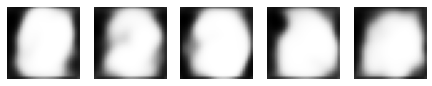

Epoch 2/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.6216 - g_loss: 8.0201 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 3/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.5975 - g_loss: 8.5500 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 4/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.5315 - g_loss: 8.9727 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


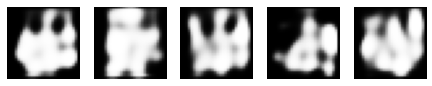

Epoch 5/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.4685 - g_loss: 9.7604 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 6/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3912 - g_loss: 10.5774 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 7/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3814 - g_loss: 10.6513 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


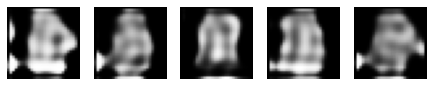

Epoch 8/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2562 - g_loss: 12.1160 - fake_accuracy: 0.0000e+00 - real_accuracy: 4.9867e-05
Epoch 9/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2794 - g_loss: 12.0209 - fake_accuracy: 0.0000e+00 - real_accuracy: 9.9734e-05
Epoch 10/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2132 - g_loss: 12.8152 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.8285e-04


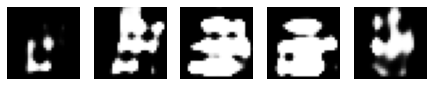

Epoch 11/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.1392 - g_loss: 13.6468 - fake_accuracy: 0.0000e+00 - real_accuracy: 5.1529e-04
Epoch 12/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.1048 - g_loss: 14.0610 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0068
Epoch 13/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.1248 - g_loss: 13.8711 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0175


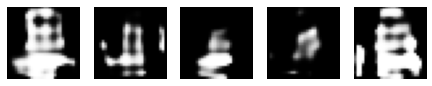

Epoch 14/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2015 - g_loss: 13.0419 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0056
Epoch 15/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3769 - g_loss: 11.3215 - fake_accuracy: 0.0000e+00 - real_accuracy: 3.6569e-04
Epoch 16/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.4445 - g_loss: 10.9733 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0023


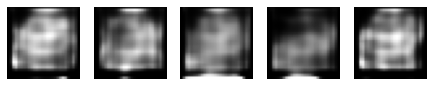

Epoch 17/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2752 - g_loss: 12.7244 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0164
Epoch 18/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2163 - g_loss: 12.7774 - fake_accuracy: 0.0000e+00 - real_accuracy: 8.4774e-04
Epoch 19/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.1876 - g_loss: 13.2005 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0012


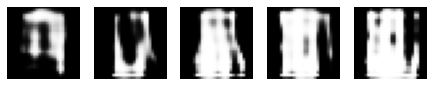

Epoch 20/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.1388 - g_loss: 13.7293 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0019
Epoch 21/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.1422 - g_loss: 13.7998 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0034
Epoch 22/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.1038 - g_loss: 14.1978 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0078


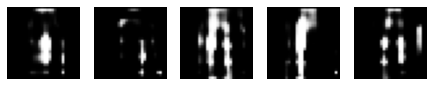

Epoch 23/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.0978 - g_loss: 14.2720 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0119
Epoch 24/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.1135 - g_loss: 14.1100 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0160
Epoch 25/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2199 - g_loss: 13.1451 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0037


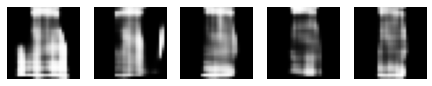

Epoch 26/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3128 - g_loss: 12.1787 - fake_accuracy: 0.0000e+00 - real_accuracy: 7.6463e-04
Epoch 27/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3480 - g_loss: 11.8078 - fake_accuracy: 0.0000e+00 - real_accuracy: 4.9867e-04
Epoch 28/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.4105 - g_loss: 11.3397 - fake_accuracy: 0.0000e+00 - real_accuracy: 2.3271e-04


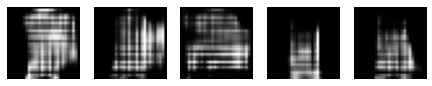

Epoch 29/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.6885 - g_loss: 9.4635 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 30/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3935 - g_loss: 11.2170 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 31/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2288 - g_loss: 12.7043 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


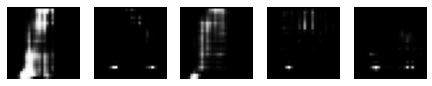

Epoch 32/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.1745 - g_loss: 13.2773 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 33/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2133 - g_loss: 12.9734 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 34/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2033 - g_loss: 13.0404 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


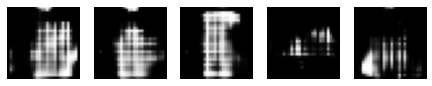

Epoch 35/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2518 - g_loss: 12.5160 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 36/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2916 - g_loss: 12.0087 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 37/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2781 - g_loss: 12.0834 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


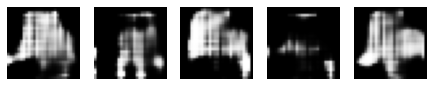

Epoch 38/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2621 - g_loss: 12.2469 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 39/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2710 - g_loss: 12.1538 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 40/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.2883 - g_loss: 11.9985 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.6622e-05


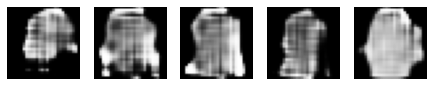

Epoch 41/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3197 - g_loss: 11.7501 - fake_accuracy: 0.0000e+00 - real_accuracy: 3.3245e-05
Epoch 42/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3556 - g_loss: 11.4348 - fake_accuracy: 0.0000e+00 - real_accuracy: 3.3245e-05
Epoch 43/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3650 - g_loss: 11.3645 - fake_accuracy: 0.0000e+00 - real_accuracy: 3.3245e-05


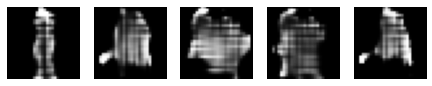

Epoch 44/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.3411 - g_loss: 11.6173 - fake_accuracy: 0.0000e+00 - real_accuracy: 9.9734e-05
Epoch 45/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.3271 - g_loss: 11.7534 - fake_accuracy: 0.0000e+00 - real_accuracy: 9.9734e-05
Epoch 46/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3173 - g_loss: 11.8080 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.1636e-04


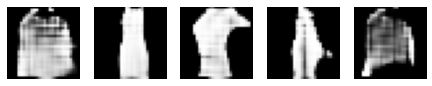

Epoch 47/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3226 - g_loss: 11.7629 - fake_accuracy: 0.0000e+00 - real_accuracy: 6.6489e-05
Epoch 48/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3571 - g_loss: 11.4300 - fake_accuracy: 0.0000e+00 - real_accuracy: 6.6489e-05
Epoch 49/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3921 - g_loss: 11.0906 - fake_accuracy: 0.0000e+00 - real_accuracy: 8.3112e-05


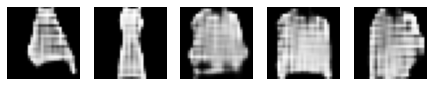

Epoch 50/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.3981 - g_loss: 11.0466 - fake_accuracy: 0.0000e+00 - real_accuracy: 8.3112e-05
Epoch 51/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4199 - g_loss: 10.8971 - fake_accuracy: 0.0000e+00 - real_accuracy: 6.6489e-05
Epoch 52/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4516 - g_loss: 10.6535 - fake_accuracy: 0.0000e+00 - real_accuracy: 6.6489e-05


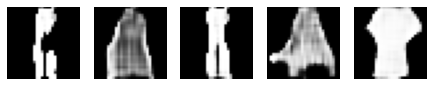

Epoch 53/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4529 - g_loss: 10.6274 - fake_accuracy: 0.0000e+00 - real_accuracy: 3.3245e-05
Epoch 54/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4561 - g_loss: 10.5852 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.6622e-05
Epoch 55/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4661 - g_loss: 10.5050 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.6622e-05


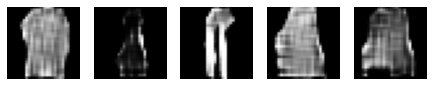

Epoch 56/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4798 - g_loss: 10.3992 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.6622e-05
Epoch 57/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4984 - g_loss: 10.2146 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.6622e-05
Epoch 58/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5073 - g_loss: 10.1168 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.6622e-05


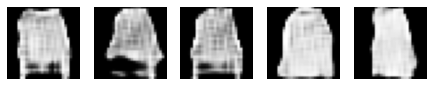

Epoch 59/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5144 - g_loss: 10.0358 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.6622e-05
Epoch 60/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5164 - g_loss: 10.0157 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.6622e-05
Epoch 61/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5188 - g_loss: 9.9516 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.6622e-05


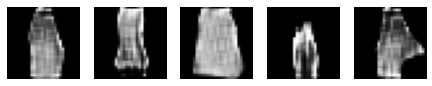

Epoch 62/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5277 - g_loss: 9.8554 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.6622e-05
Epoch 63/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.5295 - g_loss: 9.8315 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 64/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5231 - g_loss: 9.8693 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


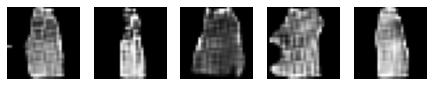

Epoch 65/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5188 - g_loss: 9.8826 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 66/200
234/234 [==============================] - 4s 16ms/step - d_loss: 0.5306 - g_loss: 9.7862 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 67/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5294 - g_loss: 9.7607 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


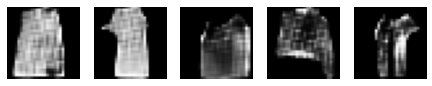

Epoch 68/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5169 - g_loss: 9.8124 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 69/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5077 - g_loss: 9.8827 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 70/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5109 - g_loss: 9.8512 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


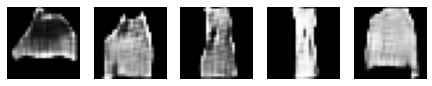

Epoch 71/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5185 - g_loss: 9.7766 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 72/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5188 - g_loss: 9.7691 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 73/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5173 - g_loss: 9.7948 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


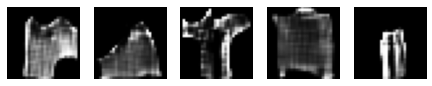

Epoch 74/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5161 - g_loss: 9.7825 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.6622e-05
Epoch 75/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5120 - g_loss: 9.8311 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.6622e-05
Epoch 76/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5118 - g_loss: 9.7963 - fake_accuracy: 0.0000e+00 - real_accuracy: 4.9867e-05


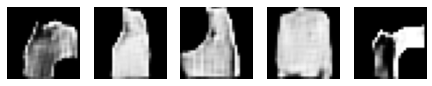

Epoch 77/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5163 - g_loss: 9.7643 - fake_accuracy: 0.0000e+00 - real_accuracy: 3.3245e-05
Epoch 78/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5181 - g_loss: 9.7392 - fake_accuracy: 0.0000e+00 - real_accuracy: 8.3112e-05
Epoch 79/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5134 - g_loss: 9.7870 - fake_accuracy: 0.0000e+00 - real_accuracy: 4.9867e-05


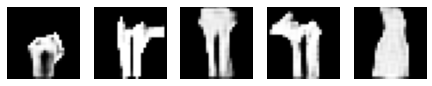

Epoch 80/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5132 - g_loss: 9.7966 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.3298e-04
Epoch 81/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5143 - g_loss: 9.7734 - fake_accuracy: 0.0000e+00 - real_accuracy: 1.8285e-04
Epoch 82/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5157 - g_loss: 9.7679 - fake_accuracy: 0.0000e+00 - real_accuracy: 2.8258e-04


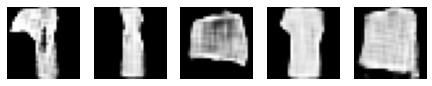

Epoch 83/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5131 - g_loss: 9.7883 - fake_accuracy: 0.0000e+00 - real_accuracy: 3.4907e-04
Epoch 84/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5093 - g_loss: 9.8213 - fake_accuracy: 0.0000e+00 - real_accuracy: 5.3191e-04
Epoch 85/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5090 - g_loss: 9.8438 - fake_accuracy: 0.0000e+00 - real_accuracy: 6.9814e-04


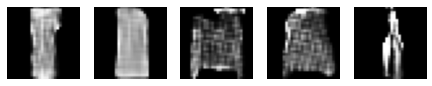

Epoch 86/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5032 - g_loss: 9.8803 - fake_accuracy: 0.0000e+00 - real_accuracy: 9.8072e-04
Epoch 87/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4990 - g_loss: 9.9111 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0012
Epoch 88/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4973 - g_loss: 9.9407 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0014


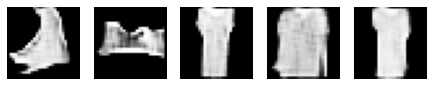

Epoch 89/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4949 - g_loss: 9.9681 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0015
Epoch 90/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4933 - g_loss: 9.9816 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0016
Epoch 91/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4935 - g_loss: 9.9741 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0019


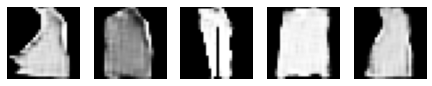

Epoch 92/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4941 - g_loss: 9.9785 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0022
Epoch 93/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4944 - g_loss: 9.9611 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0027
Epoch 94/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4961 - g_loss: 9.9426 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0028


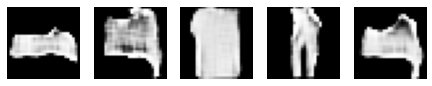

Epoch 95/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4971 - g_loss: 9.9486 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0031
Epoch 96/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4996 - g_loss: 9.9267 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0033
Epoch 97/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5016 - g_loss: 9.8946 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0036


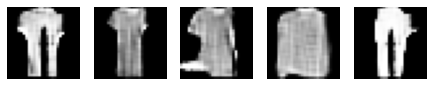

Epoch 98/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5028 - g_loss: 9.8834 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0038
Epoch 99/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5028 - g_loss: 9.8901 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0040
Epoch 100/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5026 - g_loss: 9.8685 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0043


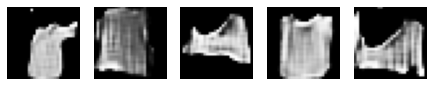

Epoch 101/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4996 - g_loss: 9.9025 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0045
Epoch 102/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4985 - g_loss: 9.9047 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0051
Epoch 103/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5000 - g_loss: 9.8852 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0055


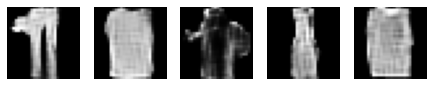

Epoch 104/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4979 - g_loss: 9.9149 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0059
Epoch 105/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4967 - g_loss: 9.9201 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0064
Epoch 106/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4967 - g_loss: 9.9386 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0068


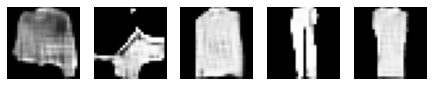

Epoch 107/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4938 - g_loss: 9.9549 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0072
Epoch 108/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4945 - g_loss: 9.9533 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0076
Epoch 109/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4920 - g_loss: 9.9726 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0079


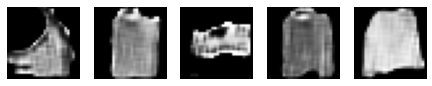

Epoch 110/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4931 - g_loss: 9.9622 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0083
Epoch 111/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4925 - g_loss: 9.9756 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0086
Epoch 112/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.4929 - g_loss: 9.9805 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0092


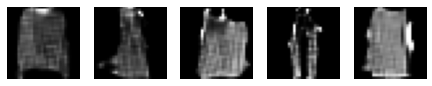

Epoch 113/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5046 - g_loss: 9.9492 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0097
Epoch 114/200
234/234 [==============================] - 4s 17ms/step - d_loss: 3.8172 - g_loss: 4.6793 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0012
Epoch 115/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.9544 - g_loss: 8.4157 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


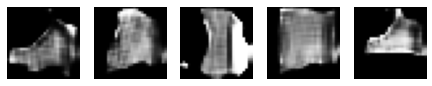

Epoch 116/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6134 - g_loss: 8.9968 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 117/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6454 - g_loss: 8.6820 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 118/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6131 - g_loss: 8.8635 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


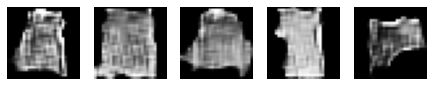

Epoch 119/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6289 - g_loss: 8.7141 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 120/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6253 - g_loss: 8.6969 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 121/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6117 - g_loss: 8.7878 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


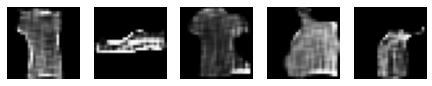

Epoch 122/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6128 - g_loss: 8.7790 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 123/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6078 - g_loss: 8.8347 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 124/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6019 - g_loss: 8.8591 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


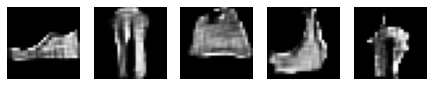

Epoch 125/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6024 - g_loss: 8.8481 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 126/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6085 - g_loss: 8.8169 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 127/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6093 - g_loss: 8.7789 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


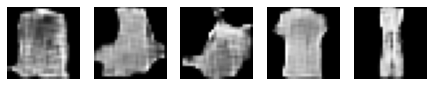

Epoch 128/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6084 - g_loss: 8.8001 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 129/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6077 - g_loss: 8.8125 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 130/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6064 - g_loss: 8.8162 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


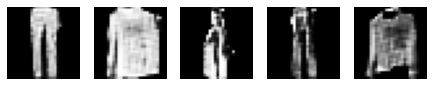

Epoch 131/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6054 - g_loss: 8.8145 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 132/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6043 - g_loss: 8.8198 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 133/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6059 - g_loss: 8.8053 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


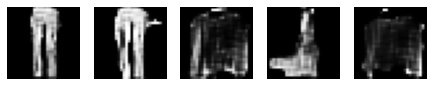

Epoch 134/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6040 - g_loss: 8.8011 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 135/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5991 - g_loss: 8.8362 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 136/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5950 - g_loss: 8.8833 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


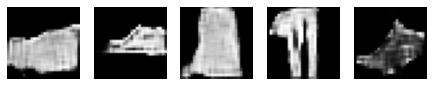

Epoch 137/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5935 - g_loss: 8.8821 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 138/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5922 - g_loss: 8.8921 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 139/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5926 - g_loss: 8.8946 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


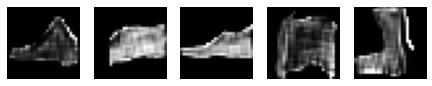

Epoch 140/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5932 - g_loss: 8.8706 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 141/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5962 - g_loss: 8.8764 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 142/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5986 - g_loss: 8.8275 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


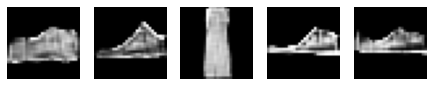

Epoch 143/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6001 - g_loss: 8.8243 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 144/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6020 - g_loss: 8.8329 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 145/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.6007 - g_loss: 8.8211 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


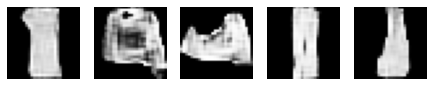

Epoch 146/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5998 - g_loss: 8.8395 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 147/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5980 - g_loss: 8.8650 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 148/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5969 - g_loss: 8.8596 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


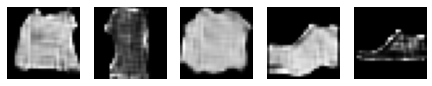

Epoch 149/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5956 - g_loss: 8.8742 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 150/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5935 - g_loss: 8.8865 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 151/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5912 - g_loss: 8.9190 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


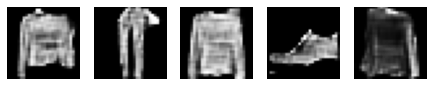

Epoch 152/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5896 - g_loss: 8.9269 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 153/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5876 - g_loss: 8.9191 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 154/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5862 - g_loss: 8.9643 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


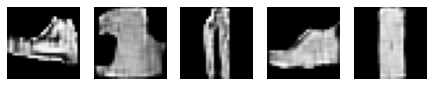

Epoch 155/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5856 - g_loss: 8.9336 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 156/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5849 - g_loss: 8.9745 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 157/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5844 - g_loss: 8.9516 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


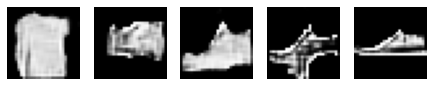

Epoch 158/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5853 - g_loss: 8.9827 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 159/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5852 - g_loss: 8.9462 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 160/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5851 - g_loss: 8.9608 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


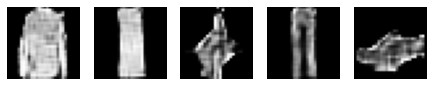

Epoch 161/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5873 - g_loss: 8.9590 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 162/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5886 - g_loss: 8.9473 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 163/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5885 - g_loss: 8.9239 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


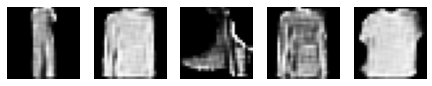

Epoch 164/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5896 - g_loss: 8.9401 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 165/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5913 - g_loss: 8.9320 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 166/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5917 - g_loss: 8.9257 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


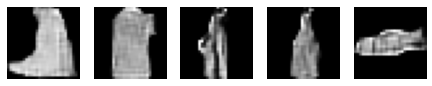

Epoch 167/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5933 - g_loss: 8.9031 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 168/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5940 - g_loss: 8.8962 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 169/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5945 - g_loss: 8.9008 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


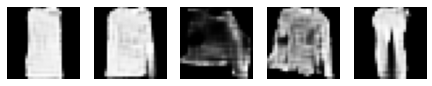

Epoch 170/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5944 - g_loss: 8.9019 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 171/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5940 - g_loss: 8.8902 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 172/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5925 - g_loss: 8.9053 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


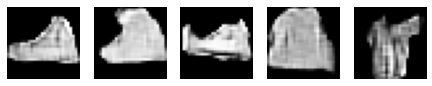

Epoch 173/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5919 - g_loss: 8.9282 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 174/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5907 - g_loss: 8.9117 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 175/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5888 - g_loss: 8.9369 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


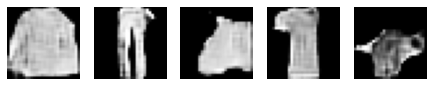

Epoch 176/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5890 - g_loss: 8.9472 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 177/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5882 - g_loss: 8.9306 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 178/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5881 - g_loss: 8.9694 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


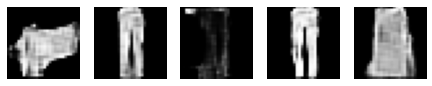

Epoch 179/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5884 - g_loss: 8.9353 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 180/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5884 - g_loss: 8.9621 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 181/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5889 - g_loss: 8.9476 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


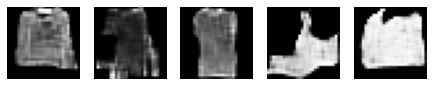

Epoch 182/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5904 - g_loss: 8.9298 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 183/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5898 - g_loss: 8.9291 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 184/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5912 - g_loss: 8.9394 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


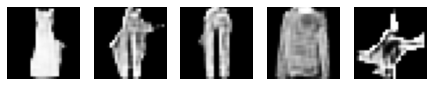

Epoch 185/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5916 - g_loss: 8.9226 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 186/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5918 - g_loss: 8.9271 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 187/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5927 - g_loss: 8.9071 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


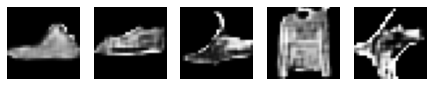

Epoch 188/200
234/234 [==============================] - 4s 17ms/step - d_loss: 0.5927 - g_loss: 8.9286 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 189/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5933 - g_loss: 8.9131 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 190/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5924 - g_loss: 8.9342 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


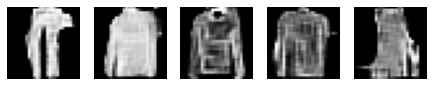

Epoch 191/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5925 - g_loss: 8.9112 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 192/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5946 - g_loss: 8.9181 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 193/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5933 - g_loss: 8.9120 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


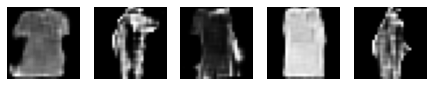

Epoch 194/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5942 - g_loss: 8.8930 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 195/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5934 - g_loss: 8.8975 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 196/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5944 - g_loss: 8.8914 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


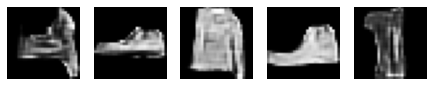

Epoch 197/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5950 - g_loss: 8.9033 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 198/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5962 - g_loss: 8.8589 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00
Epoch 199/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5964 - g_loss: 8.8810 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


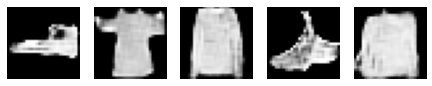

Epoch 200/200
234/234 [==============================] - 4s 18ms/step - d_loss: 0.5963 - g_loss: 8.8621 - fake_accuracy: 0.0000e+00 - real_accuracy: 0.0000e+00


In [7]:
dcgan = DCGAN(100, image_shape)

g_optimizer = RMSprop(1e-4)
d_optimizer = RMSprop(1e-4)

dcgan.compile(g_optimizer=g_optimizer, d_optimizer=d_optimizer, loss_fn=binary_crossentropy)

callbacks = [GenerativeCallback(num_imgs=5)]

dcgan.fit(ds_train, epochs=200, callbacks=callbacks)